In [1]:
!pip install roboflow
!pip install ultralytics

Defaulting to user installation because normal site-packages is not writeable
  Using cached idna-3.7-py3-none-any.whl.metadata (9.9 kB)
  Using cached python_dotenv-1.0.1-py3-none-any.whl.metadata (23 kB)
Using cached idna-3.7-py3-none-any.whl (66 kB)
Using cached python_dotenv-1.0.1-py3-none-any.whl (19 kB)
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
from ultralytics import YOLO
from roboflow import Roboflow
import os
from collections import Counter
import matplotlib.pyplot as plt
import random
import shutil
import torch
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.transforms import functional as F
from PIL import Image
import os
import json
import torch
from torchvision.datasets import CocoDetection
from torchvision.transforms import functional as F
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.metrics import precision_score, recall_score, accuracy_score
import torch
from torchvision.models.detection import FasterRCNN
# from pycocotools.coco import COCO
# from pycocotools.cocoeval import COCOeval

**Model A**

In [ ]:
rf = Roboflow(api_key="TCSCyN9gDV7Q11OvuVTc")
project = rf.workspace("shg-ymdrb").project("data_walk_asst")
version = project.version(4)
dataset = version.download("yolov8")

In [8]:
label_path = "/content/Data_Walk_Asst-4/train/labels"

# Analyze class distribution
class_counts = Counter()
for label_file in os.listdir(label_path):
    if label_file.endswith(".txt"):  # Ensure it's a label file
        with open(os.path.join(label_path, label_file), 'r') as file:
            for line in file:
                class_id = line.split()[0]  # Assuming the class ID is the first item
                class_counts[class_id] += 1

# Print the class distribution
print("Class Distribution:", class_counts)

Class Distribution: Counter({'8': 2461, '9': 2208, '3': 2106, '6': 2064, '0': 1998, '4': 1764, '5': 1719, '7': 1710, '1': 1566, '2': 1548})


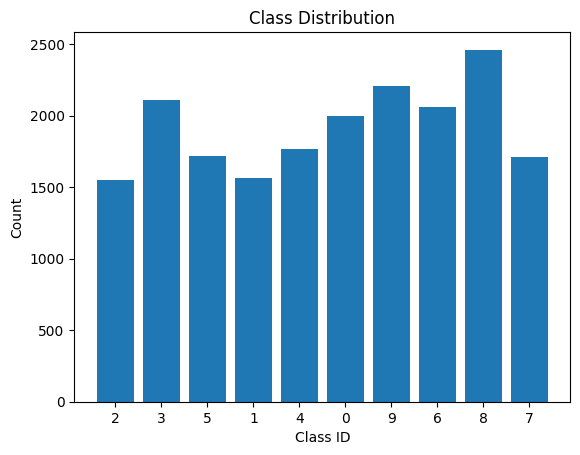

In [11]:
plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel("Class ID")
plt.ylabel("Count")
plt.title("Class Distribution")
plt.show()

In [13]:
target_count = min(class_counts.values())

In [14]:
class_files = {cls: [] for cls in class_counts.keys()}
for label_file in os.listdir(label_path):
    if label_file.endswith(".txt"):
        with open(os.path.join(label_path, label_file), 'r') as file:
            for line in file:
                class_id = line.split()[0]
                class_files[class_id].append(label_file)

In [16]:
image_path = '/content/Data_Walk_Asst-4/train/images'
for cls, files in class_files.items():
    if len(files) > target_count:
        files_to_remove = random.sample(files, len(files) - target_count)
        for file in files_to_remove:
            # Delete the label file
            label_file_path = os.path.join(label_path, file)
            if os.path.exists(label_file_path):
                os.remove(label_file_path)
                print(f"Deleted: {label_file_path}")

            # Delete the corresponding image file
            image_file_path = os.path.join(image_path, file.replace('.txt', '.jpg'))
            if os.path.exists(image_file_path):
                os.remove(image_file_path)
                print(f"Deleted: {image_file_path}")

Streaming output truncated to the last 5000 lines.
Deleted: /content/Data_Walk_Asst-4/train/labels/tempatsampah_27_jpg.rf.60cb30daaf0fd77eba5d04fcca7b54c4.txt
Deleted: /content/Data_Walk_Asst-4/train/images/tempatsampah_27_jpg.rf.60cb30daaf0fd77eba5d04fcca7b54c4.jpg
Deleted: /content/Data_Walk_Asst-4/train/labels/th-21-_jpeg_jpg.rf.44556f927ae308596e07b02b4c2401b2.txt
Deleted: /content/Data_Walk_Asst-4/train/images/th-21-_jpeg_jpg.rf.44556f927ae308596e07b02b4c2401b2.jpg
Deleted: /content/Data_Walk_Asst-4/train/labels/Outdoor-Garbage-bin-30-Liter-zoco-ae_jpg.rf.4768c86db21b16ba740f46f88fc9d25b.txt
Deleted: /content/Data_Walk_Asst-4/train/images/Outdoor-Garbage-bin-30-Liter-zoco-ae_jpg.rf.4768c86db21b16ba740f46f88fc9d25b.jpg
Deleted: /content/Data_Walk_Asst-4/train/labels/Waste-container_1_jpg.rf.e4a9af9378be3cc4c5c08dc4ac0b60cc.txt
Deleted: /content/Data_Walk_Asst-4/train/images/Waste-container_1_jpg.rf.e4a9af9378be3cc4c5c08dc4ac0b60cc.jpg
Deleted: /content/Data_Walk_Asst-4/train/labels

In [17]:
class_counts_after = Counter()
for label_file in os.listdir(label_path):
    if label_file.endswith(".txt"):
        with open(os.path.join(label_path, label_file), 'r') as file:
            for line in file:
                class_id = line.split()[0]
                class_counts_after[class_id] += 1

print("New Class Distribution:", class_counts_after)

New Class Distribution: Counter({'2': 1546, '5': 1529, '4': 1467, '7': 1445, '1': 1420, '9': 1216, '3': 1158, '6': 1007, '0': 989, '8': 558})


In [18]:
model1 = YOLO("yolov8n.pt")

100%|██████████| 6.25M/6.25M [00:00<00:00, 71.2MB/s]


In [20]:
model1.train(data="/content/Data_Walk_Asst-4/data.yaml", epochs=10, batch=32, name="model1")

Ultralytics 8.3.34 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/Data_Walk_Asst-4/data.yaml, epochs=10, time=None, patience=100, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=model12, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, sh

100%|██████████| 755k/755k [00:00<00:00, 14.9MB/s]


Overriding model.yaml nc=80 with nc=10

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytic

100%|██████████| 5.35M/5.35M [00:00<00:00, 41.2MB/s]


AMP: checks passed ✅


train: Scanning /content/Data_Walk_Asst-4/train/labels... 11132 images, 1785 backgrounds, 0 corrupt: 100%|██████████| 11132/11132 [00:08<00:00, 1258.58it/s]

train: WARNING ⚠️ /content/Data_Walk_Asst-4/train/images/189_jpg.rf.19d4cbdb6976acd42e0223977fd14b9f.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /content/Data_Walk_Asst-4/train/images/189_jpg.rf.8afd1c0ab9afa9572e8ebbe47f5be1b5.jpg: 1 duplicate labels removed


train: New cache created: /content/Data_Walk_Asst-4/train/labels.cache
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 1416, len(boxes) = 12333. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
val: Scanning /content/Data_Walk_Asst-4/valid/labels... 1430 images, 118 backgrounds, 0 corrupt: 100%|██████████| 1430/1430 [00:01<00:00, 997.93it/s] 


val: New cache created: /content/Data_Walk_Asst-4/valid/labels.cache
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 443, len(boxes) = 2152. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.
Plotting labels to runs/detect/model12/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/model12
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_chan

       1/10      4.31G       1.24      3.254       1.72         26        640: 100%|██████████| 348/348 [00:48<00:00,  7.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.34it/s]


                   all       1430       2152      0.529      0.495      0.493      0.303

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      4.28G      1.219       1.98      1.662         29        640: 100%|██████████| 348/348 [00:44<00:00,  7.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:05<00:00,  4.58it/s]

                   all       1430       2152      0.646      0.548      0.599      0.367



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10       4.3G      1.185      1.536      1.633         31        640: 100%|██████████| 348/348 [00:42<00:00,  8.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:05<00:00,  4.53it/s]

                   all       1430       2152      0.677      0.572      0.615      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      4.28G      1.146      1.338      1.601         35        640: 100%|██████████| 348/348 [00:42<00:00,  8.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:04<00:00,  4.63it/s]

                   all       1430       2152      0.713      0.606      0.658      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      4.27G      1.074      1.149       1.53         33        640: 100%|██████████| 348/348 [00:42<00:00,  8.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:04<00:00,  4.62it/s]

                   all       1430       2152      0.773      0.657      0.716      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      4.28G      1.006      1.004      1.471         24        640: 100%|██████████| 348/348 [00:42<00:00,  8.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:04<00:00,  4.64it/s]

                   all       1430       2152      0.778      0.661      0.727      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      4.29G     0.9476     0.8929      1.419         33        640: 100%|██████████| 348/348 [00:42<00:00,  8.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:04<00:00,  4.64it/s]

                   all       1430       2152      0.797      0.684      0.748      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      4.27G     0.8874     0.8029      1.359         25        640: 100%|██████████| 348/348 [00:42<00:00,  8.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:04<00:00,  4.66it/s]

                   all       1430       2152      0.776      0.702      0.757      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      4.27G     0.8377     0.7372       1.32         29        640: 100%|██████████| 348/348 [00:42<00:00,  8.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:04<00:00,  4.67it/s]

                   all       1430       2152      0.831      0.709      0.782      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      4.29G     0.7849     0.6657      1.281         34        640: 100%|██████████| 348/348 [00:42<00:00,  8.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:04<00:00,  4.63it/s]

                   all       1430       2152      0.809      0.743      0.788      0.575



10 epochs completed in 0.138 hours.
Optimizer stripped from runs/detect/model12/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/model12/weights/best.pt, 6.2MB

Validating runs/detect/model12/weights/best.pt...
Ultralytics 8.3.34 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
Model summary (fused): 168 layers, 3,007,598 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.58it/s]


                   all       1430       2152      0.808      0.744      0.788      0.575
             barricade         82        193      0.811      0.725      0.794      0.604
            close_door        179        215      0.727      0.781      0.799      0.613
             crosswalk        147        187      0.839      0.779      0.831      0.557
               dustbin        123        230      0.892      0.864      0.897      0.701
              elevator        159        183      0.895      0.918      0.933      0.625
                   fan        186        190      0.983      0.995      0.995      0.919
              handrail        173        237      0.792      0.724      0.792      0.518
             open_door        168        185      0.736      0.799      0.814      0.614
               pothole         97        296      0.773      0.461       0.58      0.318
                stairs        215        236      0.635       0.39       0.45      0.283
Speed: 0.1ms preproce

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7a81024983d0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.0

In [22]:
from google.colab import files
files.download('/content/runs/detect/model12/weights/best.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Model2**

In [3]:
rf = Roboflow(api_key="TCSCyN9gDV7Q11OvuVTc")
project = rf.workspace("shg-ymdrb").project("data_walk_asst")
version = project.version(4)
dataset = version.download("coco")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Data_Walk_Asst-4 in coco:: 100%|██████████| 16784/16784 [00:03<00:00, 4859.38it/s]


In [4]:
dataset_path = "/content/Data_Walk_Asst-4"  # Replace with your dataset folder path
annotations_file = os.path.join(dataset_path, "train", "_annotations.coco.json")  # Adjust if in "train" folder
images_folder = os.path.join(dataset_path, "train", "images")


In [5]:
class CustomCocoDataset(CocoDetection):
    def __init__(self, root, ann_file, transforms=None):
        super().__init__(root=root, annFile=ann_file)
        self.transforms = transforms

    def __getitem__(self, idx):
        img, target = super().__getitem__(idx)

        # Filter out images without annotations
        if len(target) == 0:
            return self.__getitem__((idx + 1) % len(self))

        # Convert PIL image to tensor
        img = F.to_tensor(img)

        # Map COCO-style annotations to PyTorch format
        target = {
            "boxes": torch.tensor([obj["bbox"] for obj in target], dtype=torch.float32),
            "labels": torch.tensor([obj["category_id"] for obj in target], dtype=torch.int64),
            "image_id": torch.tensor([idx])
        }

        # Ensure bounding boxes are in [x_min, y_min, x_max, y_max] format
        target["boxes"][:, 2:] += target["boxes"][:, :2]

        if self.transforms:
            img = self.transforms(img)

        return img, target


In [6]:
train_dataset = CustomCocoDataset(
    root="/content/Data_Walk_Asst-4/train",
    ann_file="/content/Data_Walk_Asst-4/train/_annotations.coco.json"
)

val_dataset = CustomCocoDataset(
    root="/content/Data_Walk_Asst-4/valid",
    ann_file="/content/Data_Walk_Asst-4/valid/_annotations.coco.json"
)

loading annotations into memory...
Done (t=0.22s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [7]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [8]:
train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    collate_fn=collate_fn
)

val_loader = DataLoader(
    val_dataset,
    batch_size=32,
    shuffle=False,
    collate_fn=collate_fn
)

In [10]:
import torchvision

In [11]:
# model = fasterrcnn_resnet50_fpn(pretrained=True)
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 207MB/s]


In [12]:
num_classes = len(train_dataset.coco.getCatIds())  # For COCO, there are 80 classes + 1 for background
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)

In [13]:
# num_classes = len(train_dataset.coco.getCatIds()) + 1  # Number of classes + background
# in_features = model.roi_heads.box_predictor.cls_score.in_features
# model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [14]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [15]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.AdamW(params, lr=1e-4)

In [16]:
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)


In [17]:
num_epochs = 3
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, targets in train_loader:
        images = [image.to(device) for image in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Forward pass
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        # Backward pass
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        # Track the loss
        running_loss += losses.item()

    # Scheduler step
    lr_scheduler.step()

    # Print the average loss for this epoch
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss / len(train_loader):.4f}')

Epoch 1/3, Loss: 0.2324
Epoch 2/3, Loss: 0.1425
Epoch 3/3, Loss: 0.1144


In [18]:
torch.save(model.state_dict(), 'FRCNN_A.pth')

In [19]:
def evaluate(model, data_loader, device):
    model.eval()  # Set model to evaluation mode
    all_preds = []  # To store all predictions
    all_targets = []  # To store all ground truth labels

    # Initialize counters for precision, recall, and accuracy
    tp, fp, fn, tn = 0, 0, 0, 0

    with torch.no_grad():
        for images, targets in data_loader:
            images = [image.to(device) for image in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            # Get model predictions
            predictions = model(images)

            # Compare predictions with ground truth
            for pred, target in zip(predictions, targets):
                pred_boxes = pred['boxes']
                pred_labels = pred['labels']
                pred_scores = pred['scores']
                target_boxes = target['boxes']
                target_labels = target['labels']

                # For each predicted box, check if it matches a ground truth box
                for i in range(len(pred_boxes)):
                    pred_box = pred_boxes[i]
                    pred_label = pred_labels[i]
                    score = pred_scores[i]

                    # Assume a detection is positive if it has a high enough confidence
                    if score >= 0.5:  # Threshold for considering a detection
                        # Check if the predicted label matches the ground truth
                        if pred_label in target_labels:
                            tp += 1  # True positive
                        else:
                            fp += 1  # False positive
                    else:
                        fn += 1  # False negative

                # Count true negatives (for this, you would need to track background class)
                tn += 1  # This part can vary depending on how you define 'negative'

    # Calculate precision, recall, and accuracy
    precision = tp / (tp + fp) if tp + fp > 0 else 0
    recall = tp / (tp + fn) if tp + fn > 0 else 0
    accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0

    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'Accuracy: {accuracy:.4f}')



In [20]:
evaluate(model, val_loader, device)

Precision: 0.8922
Recall: 0.3712
Accuracy: 0.4685


**Model 3**

In [95]:
rf = Roboflow(api_key="TCSCyN9gDV7Q11OvuVTc")
project = rf.workspace("generalobjects2").project("general-object-detection-2")
version = project.version(3)
dataset = version.download("yolov8")


loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to general-object-detection-2-3 in yolov8:: 100%|██████████| 45662/45662 [00:06<00:00, 7427.40it/s]


In [96]:
label_path = "/content/general-object-detection-2-3/train/labels"

# Analyze class distribution
class_counts = Counter()
for label_file in os.listdir(label_path):
    if label_file.endswith(".txt"):  # Ensure it's a label file
        with open(os.path.join(label_path, label_file), 'r') as file:
            for line in file:
                class_id = line.split()[0]  # Assuming the class ID is the first item
                class_counts[class_id] += 1

# Print the class distribution
print("Class Distribution:", class_counts)

Class Distribution: Counter({'4': 6314, '0': 3648, '5': 2023, '2': 1563, '9': 1448, '3': 1287, '1': 1203, '8': 1182, '7': 876, '6': 740})


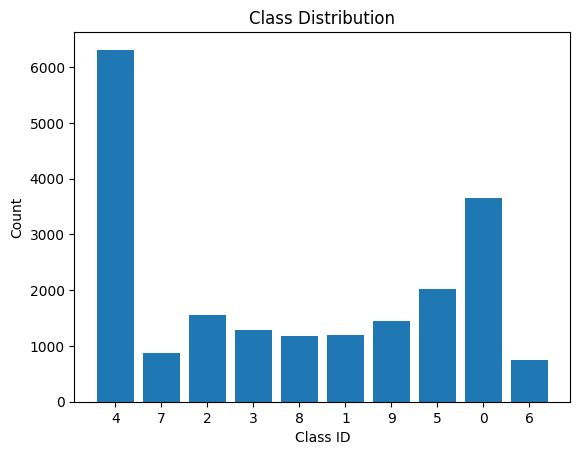

In [97]:
plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel("Class ID")
plt.ylabel("Count")
plt.title("Class Distribution")
plt.show()

In [98]:
target_count = min(class_counts.values())

In [99]:
class_files = {cls: [] for cls in class_counts.keys()}
for label_file in os.listdir(label_path):
    if label_file.endswith(".txt"):
        with open(os.path.join(label_path, label_file), 'r') as file:
            for line in file:
                class_id = line.split()[0]
                class_files[class_id].append(label_file)

In [100]:
image_path = '/content/general-object-detection-2-3/train/images'
for cls, files in class_files.items():
    if len(files) > target_count:
        files_to_remove = random.sample(files, len(files) - target_count)
        for file in files_to_remove:
            # Delete the label file
            label_file_path = os.path.join(label_path, file)
            if os.path.exists(label_file_path):
                os.remove(label_file_path)
                print(f"Deleted: {label_file_path}")

            # Delete the corresponding image file
            image_file_path = os.path.join(image_path, file.replace('.txt', '.jpg'))
            if os.path.exists(image_file_path):
                os.remove(image_file_path)
                print(f"Deleted: {image_file_path}")

Streaming output truncated to the last 5000 lines.
Deleted: /content/general-object-detection-2-3/train/labels/img285_jpg.rf.c3711c29468e84e39c1e24bb58af279f.txt
Deleted: /content/general-object-detection-2-3/train/images/img285_jpg.rf.c3711c29468e84e39c1e24bb58af279f.jpg
Deleted: /content/general-object-detection-2-3/train/labels/img714_jpg.rf.147161c61bc93de70b5841def785eb02.txt
Deleted: /content/general-object-detection-2-3/train/images/img714_jpg.rf.147161c61bc93de70b5841def785eb02.jpg
Deleted: /content/general-object-detection-2-3/train/labels/0beb9cbe0c770abf_jpg.rf.4adcb266c94961e7e2b3ad8c241dece3.txt
Deleted: /content/general-object-detection-2-3/train/images/0beb9cbe0c770abf_jpg.rf.4adcb266c94961e7e2b3ad8c241dece3.jpg
Deleted: /content/general-object-detection-2-3/train/labels/img288_jpg.rf.8a58adc25166825d8df4f7144c607aed.txt
Deleted: /content/general-object-detection-2-3/train/images/img288_jpg.rf.8a58adc25166825d8df4f7144c607aed.jpg
Deleted: /content/general-object-detectio

In [101]:
class_counts_after = Counter()
for label_file in os.listdir(label_path):
    if label_file.endswith(".txt"):
        with open(os.path.join(label_path, label_file), 'r') as file:
            for line in file:
                class_id = line.split()[0]
                class_counts_after[class_id] += 1

print("New Class Distribution:", class_counts_after)

New Class Distribution: Counter({'6': 740, '3': 714, '7': 705, '8': 677, '1': 661, '0': 618, '2': 589, '5': 485, '9': 354, '4': 336})


In [102]:
model3 = YOLO("yolov8n.pt")

100%|██████████| 6.25M/6.25M [00:00<00:00, 367MB/s]


In [104]:
model3.train(data="/content/general-object-detection-2-3/data.yaml", epochs=10, batch=32, name="model3")

Ultralytics 8.3.34 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/general-object-detection-2-3/data.yaml, epochs=10, time=None, patience=100, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=model3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labe

100%|██████████| 5.35M/5.35M [00:00<00:00, 235MB/s]


AMP: checks passed ✅


train: Scanning /content/general-object-detection-2-3/train/labels... 9565 images, 3949 backgrounds, 0 corrupt: 100%|██████████| 9565/9565 [00:07<00:00, 1364.85it/s]


train: New cache created: /content/general-object-detection-2-3/train/labels.cache
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 256, len(boxes) = 5879. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
val: Scanning /content/general-object-detection-2-3/valid/labels... 2252 images, 668 backgrounds, 0 corrupt: 100%|██████████| 2252/2252 [00:02<00:00, 1059.61it/s]


val: New cache created: /content/general-object-detection-2-3/valid/labels.cache
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 39, len(boxes) = 2257. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.
Plotting labels to runs/detect/model3/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/model3
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_ou

       1/10      28.8G      1.002      4.153      1.679         17        640: 100%|██████████| 299/299 [00:40<00:00,  7.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:09<00:00,  3.93it/s]


                   all       2252       2257      0.623       0.27      0.301      0.166

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      6.43G     0.9823       2.49      1.673         20        640: 100%|██████████| 299/299 [00:37<00:00,  7.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:07<00:00,  5.02it/s]

                   all       2252       2257      0.572      0.332      0.339      0.182



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      6.41G     0.9725      1.774       1.65         16        640: 100%|██████████| 299/299 [00:36<00:00,  8.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:07<00:00,  5.00it/s]

                   all       2252       2257      0.497      0.325      0.349      0.199



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      6.41G     0.9507      1.497       1.62         19        640: 100%|██████████| 299/299 [00:36<00:00,  8.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:07<00:00,  5.09it/s]

                   all       2252       2257      0.651      0.369      0.412      0.261



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      6.41G     0.8715      1.252      1.547         19        640: 100%|██████████| 299/299 [00:36<00:00,  8.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:07<00:00,  5.11it/s]

                   all       2252       2257      0.595      0.402      0.446      0.297



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      6.41G     0.8188      1.083      1.498         18        640: 100%|██████████| 299/299 [00:36<00:00,  8.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:07<00:00,  5.06it/s]

                   all       2252       2257       0.71      0.394      0.463      0.308



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      6.41G     0.7758     0.9575      1.448         14        640: 100%|██████████| 299/299 [00:36<00:00,  8.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:07<00:00,  5.09it/s]

                   all       2252       2257      0.684      0.414      0.489      0.339



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      6.41G     0.7292      0.868      1.403         12        640: 100%|██████████| 299/299 [00:36<00:00,  8.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:06<00:00,  5.31it/s]

                   all       2252       2257      0.683      0.432      0.487      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      6.41G     0.6803     0.7728      1.358         17        640: 100%|██████████| 299/299 [00:36<00:00,  8.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:06<00:00,  5.19it/s]

                   all       2252       2257       0.72      0.451      0.516      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      6.41G     0.6422      0.693      1.317         15        640: 100%|██████████| 299/299 [00:36<00:00,  8.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:06<00:00,  5.15it/s]

                   all       2252       2257      0.675      0.478      0.533      0.386



10 epochs completed in 0.126 hours.
Optimizer stripped from runs/detect/model3/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/model3/weights/best.pt, 6.2MB

Validating runs/detect/model3/weights/best.pt...
Ultralytics 8.3.34 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
Model summary (fused): 168 layers, 3,007,598 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:07<00:00,  4.50it/s]


                   all       2252       2257      0.682      0.475      0.533      0.385
                   Bed        356        403      0.795      0.683      0.764      0.565
               Cabinet        136        158      0.744      0.349      0.433      0.307
                 Chair        163        231      0.853      0.385      0.456      0.344
                 Couch        183        203      0.818      0.675       0.72      0.564
            Countertop        171        277       0.67      0.176      0.334      0.155
                  Door        276        348      0.759      0.353      0.424      0.281
                Heater         66         70      0.681      0.886       0.88      0.669
                 Shelf        150        178      0.593      0.837      0.817      0.648
                 Table        213        246      0.803      0.382      0.473      0.311
                Window         91        143      0.107      0.021     0.0266     0.0106
Speed: 0.1ms preproce

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7e54dc1ef0a0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.0

In [107]:
files.download('/content/runs/detect/model3/weights/best.pt')

**Model 4**

In [3]:
rf = Roboflow(api_key="TCSCyN9gDV7Q11OvuVTc")
project = rf.workspace("generalobjects2").project("general-object-detection-2")
version = project.version(3)
dataset = version.download("coco")


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to general-object-detection-2-3 in coco:: 100%|██████████| 22833/22833 [00:04<00:00, 5007.68it/s]


In [4]:
dataset_path = "/content/general-object-detection-2-3"  # Replace with your dataset folder path
annotations_file = os.path.join(dataset_path, "train", "_annotations.coco.json")  # Adjust if in "train" folder
images_folder = os.path.join(dataset_path, "train", "images")


In [5]:
class CustomCocoDataset(CocoDetection):
    def __init__(self, root, ann_file, transforms=None):
        super().__init__(root=root, annFile=ann_file)
        self.transforms = transforms

    def __getitem__(self, idx):
        img, target = super().__getitem__(idx)

        # Filter out images without annotations
        if len(target) == 0:
            return self.__getitem__((idx + 1) % len(self))

        # Convert PIL image to tensor
        img = F.to_tensor(img)

        # Map COCO-style annotations to PyTorch format
        target = {
            "boxes": torch.tensor([obj["bbox"] for obj in target], dtype=torch.float32),
            "labels": torch.tensor([obj["category_id"] for obj in target], dtype=torch.int64),
            "image_id": torch.tensor([idx])
        }

        # Ensure bounding boxes are in [x_min, y_min, x_max, y_max] format
        target["boxes"][:, 2:] += target["boxes"][:, :2]

        if self.transforms:
            img = self.transforms(img)

        return img, target


In [6]:
train_dataset = CustomCocoDataset(
    root="/content/general-object-detection-2-3/train",
    ann_file="/content/general-object-detection-2-3/train/_annotations.coco.json"
)

val_dataset = CustomCocoDataset(
    root="/content/general-object-detection-2-3/valid",
    ann_file="/content/general-object-detection-2-3/valid/_annotations.coco.json"
)

loading annotations into memory...
Done (t=0.25s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [7]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [8]:
train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    collate_fn=collate_fn
)

val_loader = DataLoader(
    val_dataset,
    batch_size=32,
    shuffle=False,
    collate_fn=collate_fn
)

In [9]:
import torchvision

In [10]:
# model = fasterrcnn_resnet50_fpn(pretrained=True)
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 197MB/s]


In [11]:
num_classes = len(train_dataset.coco.getCatIds())  # For COCO, there are 80 classes + 1 for background
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)

In [12]:
# num_classes = len(train_dataset.coco.getCatIds()) + 1  # Number of classes + background
# in_features = model.roi_heads.box_predictor.cls_score.in_features
# model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [13]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [14]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.AdamW(params, lr=1e-4)

In [15]:
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)


In [16]:
num_epochs = 3
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, targets in train_loader:
        images = [image.to(device) for image in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Forward pass
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        # Backward pass
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        # Track the loss
        running_loss += losses.item()

    # Scheduler step
    lr_scheduler.step()

    # Print the average loss for this epoch
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss / len(train_loader):.4f}')

Epoch 1/3, Loss: 0.1876
Epoch 2/3, Loss: 0.1229
Epoch 3/3, Loss: 0.0981


In [17]:
torch.save(model.state_dict(), 'FRCNN_B.pth')

In [18]:

def evaluate(model, data_loader, device):
    model.eval()  # Set model to evaluation mode
    all_preds = []  # To store all predictions
    all_targets = []  # To store all ground truth labels

    # Initialize counters for precision, recall, and accuracy
    tp, fp, fn, tn = 0, 0, 0, 0

    with torch.no_grad():
        for images, targets in data_loader:
            images = [image.to(device) for image in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            # Get model predictions
            predictions = model(images)

            # Compare predictions with ground truth
            for pred, target in zip(predictions, targets):
                pred_boxes = pred['boxes']
                pred_labels = pred['labels']
                pred_scores = pred['scores']
                target_boxes = target['boxes']
                target_labels = target['labels']

                # For each predicted box, check if it matches a ground truth box
                for i in range(len(pred_boxes)):
                    pred_box = pred_boxes[i]
                    pred_label = pred_labels[i]
                    score = pred_scores[i]

                    # Assume a detection is positive if it has a high enough confidence
                    if score >= 0.5:  # Threshold for considering a detection
                        # Check if the predicted label matches the ground truth
                        if pred_label in target_labels:
                            tp += 1  # True positive
                        else:
                            fp += 1  # False positive
                    else:
                        fn += 1  # False negative

                # Count true negatives (for this, you would need to track background class)
                tn += 1  # This part can vary depending on how you define 'negative'

    # Calculate precision, recall, and accuracy
    precision = tp / (tp + fp) if tp + fp > 0 else 0
    recall = tp / (tp + fn) if tp + fn > 0 else 0
    accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0

    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'Accuracy: {accuracy:.4f}')




In [19]:
evaluate(model, val_loader, device)

Precision: 0.6774
Recall: 0.1772
Accuracy: 0.2420


UI


In [6]:
import os
os.listdir()

['FRCNN_A.pth',
 'FRCNN_B.pth',
 'i210335_i212705_CV_A2_(1) (1).ipynb',
 'YOLO_A.pt',
 'YOLO_B.pt']

In [8]:
!pip install --upgrade pip

Defaulting to user installation because normal site-packages is not writeable
  Using cached pip-24.3.1-py3-none-any.whl.metadata (3.7 kB)
Using cached pip-24.3.1-py3-none-any.whl (1.8 MB)



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: To modify pip, please run the following command:
C:\Program Files\Python312\python.exe -m pip install --upgrade pip


In [9]:
!pip install gradio

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [13]:
import gradio as gr
import torch
from ultralytics import YOLO
import time
import cv2
import numpy as np

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [14]:
model1 = YOLO("YOLO_A.pt")
model2 = YOLO("YOLO_B.pt")

In [15]:
def object_detection(image, model_choice):
    model = model1 if model_choice == "Model 1" else model2
    start_time = time.time()
    results = model(image)  # Perform inference
    end_time = time.time()
    inference_time = end_time - start_time

    # Ensure results is handled correctly
    if isinstance(results, list):
        results = results[0]  # Get the first item if results is a list

    # Check if results contains a valid rendering method
    if hasattr(results, 'render'):
        detected_image = results.render()[0]  # Render bounding boxes on image
    else:
        # Handle cases where the rendering method isn't available
        detected_image = image  # Fallback to original image (no detections)

    # Calculate detected objects
    num_objects_found = len(results.pandas().xyxy[0]) if hasattr(results, 'pandas') else 0

    # Replace with actual values for total objects
    total_objects_in_image = 10 if model_choice == "Model 1" else 8
    score = f"{num_objects_found}/{total_objects_in_image}"

    return detected_image, score, f"{inference_time:.2f} seconds"


In [16]:
# Define options for model and dataset selection
model_options = ["Model 1", "Model 2"]
dataset_options = ["Scene 1", "Scene 2"]  # Example dataset names

# Create Gradio interface
with gr.Blocks() as demo:
    gr.Markdown("## Object Detection Frontend")

    with gr.Row():
        dataset_choice = gr.Dropdown(label="Select Dataset (Scene)", choices=dataset_options)
        model_choice = gr.Dropdown(label="Select Model", choices=model_options)

    with gr.Row():
        input_image = gr.Image(type="pil", label="Upload Image for Object Detection")

    find_button = gr.Button("Find")

    with gr.Row():
        output_image = gr.Image(label="Detected Objects")
        score_display = gr.Textbox(label="Score")
        inference_time_display = gr.Textbox(label="Inference Time")

    # Link the "Find" button to the detection function
    find_button.click(object_detection,
                      inputs=[input_image, model_choice],
                      outputs=[output_image, score_display, inference_time_display])

# Launch the interface
demo.launch(debug=True )


* Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


Keyboard interruption in main thread... closing server.
